In [1]:
# preliminaries
import sys,os,time,cv2
import numpy as np
import matplotlib.pyplot as plt
from utils import imread_to_rgb, img_rgb2bw

DB_PATH = '/home/jhchoi/datasets4/RAF/'
raf_dict = dict()

#FER: 0=angry, 1=disgust, 2=fear, 3=happy, 4=sad, 5=surprise, 6=neutral
#RAF-basic and RAF-multi:
# 1:Surprise, 2:Fear, 3:Disgust, 4:Happiness, 5:Sadness, 6:Anger, 7:Neutral
#RAF-compound:
# 1: Happily Surprised, 2: Happily Disgusted, 3: Sadly Fearful, 4: Sadly Angry, 5: Sadly Surprised, 6: Sadly Disgusted
# 7: Fearfully Angry, 8: Fearfully Surprised, 9: Angrily Surprised, 10: Angrily Disgusted, 11: Disgustedly Surprised

# translate from RAF-Basic to FER label vectors
def emo_rafb2fer(rf):
    fer_arr = [-1, 5, 2, 1, 3, 4, 0, 6]
    fer = fer_arr[rf]
    
    emo_label = np.zeros(7)
    emo_label[fer] = 1.
    return emo_label

# translate from RAF-Compound to FER label vectors
def emo_rafc2fer(rf):
    dic = [-1,      #0,1,2,3,4,5,6
           np.array([0,0,0,1,0,1,0]), #1  Happily Surprised
           np.array([0,1,0,1,0,0,0]), #2  Happily Disgusted
           np.array([0,0,1,0,1,0,0]), #3  Sadly Fearful
           np.array([1,0,0,0,1,0,0]), #4  Sadly Angry
           np.array([0,0,0,0,1,1,0]), #5  Sadly Surprised
           np.array([0,1,0,0,1,0,0]), #6  Sadly Disgusted
           np.array([1,0,1,0,0,0,0]), #7  Fearfully Angry
           np.array([0,0,1,0,0,1,0]), #8  Fearfully Surprised
           np.array([1,0,0,0,0,1,0]), #9  Angrily Surprised
           np.array([1,1,0,0,0,0,0]), #10 Angrily Disgusted
           np.array([0,1,0,0,0,1,0])  #11 Disgustedly Surprised
          ]
    fer = dic[rf].astype(float)*0.5
    return fer

# translate from RAF-Multi to FER label vectors
def emo_rafm2fer(rf):
    neu = np.max([1. - np.sum(rf), 0.])
    fer = np.array([rf[5],rf[2],rf[1],rf[3],rf[4],rf[0],neu])
    return fer


raf_b_dict = dict()
raf_c_dict = dict()
raf_m_dict = dict()


In [2]:
# add basic db
basic_path = os.path.join(DB_PATH, 'basic')
labels = np.genfromtxt(os.path.join(basic_path,'EmoLabel','list_patition_label.txt'), delimiter=' ', dtype=str)

for i,data in enumerate(labels):
    data_name = data[0]
    data_label = emo_rafb2fer(int(data[1]))
    data_bb_path = os.path.join(basic_path, 'Annotation/boundingbox', data_name.split('.')[0]+'_boundingbox.txt')
    data_bb = np.genfromtxt(data_bb_path, delimiter=' ') # (xmin,ymin,xmax,ymax)
    data_path = os.path.join('basic/Image/original', data_name)
    
    raf_b_dict[i] = {'img': data_path, 'em': data_label, 'bb': data_bb }
    

In [3]:
# add compound db
comp_path = os.path.join(DB_PATH, 'compound')
labels = np.genfromtxt(os.path.join(comp_path,'EmoLabel','list_patition_label.txt'), delimiter=' ', dtype=str)

for i,data in enumerate(labels):
    data_name = data[0]
    data_label = emo_rafc2fer(int(data[1]))
    data_bb_path = os.path.join(comp_path, 'Annotation/boundingbox', data_name.split('.')[0]+'_boundingbox.txt')
    data_bb = np.genfromtxt(data_bb_path, delimiter=' ')
    data_path = os.path.join('compound/Image/original', data_name)
    
    raf_c_dict[i] = {'img': data_path, 'em': data_label, 'bb': data_bb }


In [4]:
# add multi db
multi_path = os.path.join(DB_PATH, 'multi')
labels = np.genfromtxt(os.path.join(multi_path,'EmoLabel','distribution.txt'), delimiter=' ', dtype=str)

for i,data in enumerate(labels):
    data_name = data[0]
    data_label = emo_rafm2fer((data[1:]).astype(float))
    data_bb_path = os.path.join(multi_path, 'Annotation/manual', data_name.split('.')[0]+'_manu_ldmk.txt') 
    
    data_bb = np.genfromtxt(data_bb_path, delimiter='\t', dtype=float)
    if data_bb.ndim <2:
        #print data_name
        data_bb = np.genfromtxt(data_bb_path, delimiter=' ', dtype=float, skip_footer=3)[:,:2]
    xmin = np.min(data_bb[:,0])
    xmax = np.max(data_bb[:,0])
    ymin = np.min(data_bb[:,1])
    ymax = np.max(data_bb[:,1])
    w = xmax-xmin
    h = ymax-ymin
    m = 0.5 # h/w face margin ratio
    data_bb_mod = np.array([xmin-w*m, ymin-h*m, xmax+w*m, ymax+h*m])
    
    data_path = os.path.join('multi/Image/original', data_name)
    
    raf_m_dict[i] = {'img': data_path, 'em': data_label, 'bb': data_bb_mod }


In [5]:
i = 0
for db in raf_b_dict.keys():
    raf_dict[i] = raf_b_dict[db]
    i += 1
for db in raf_c_dict.keys():
    raf_dict[i] = raf_c_dict[db]
    i += 1
for db in raf_m_dict.keys():
    raf_dict[i] = raf_m_dict[db]
    i += 1
print i

24201


In [19]:
np.save('../../dicts/raf_parsed.npy', raf_dict, allow_pickle=True)
print 'saved'


saved


[0.       0.055556 0.5      0.       0.111111 0.333333 0.      ]


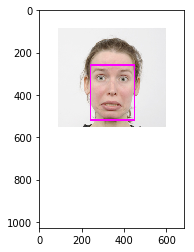

In [24]:
data = raf_dict[20000]
print data['em']
data['bb'] = data['bb'].astype(int)
im = plt.imread(os.path.join(DB_PATH, data['img']))
im = cv2.rectangle(im, (data['bb'][0],data['bb'][1]), (data['bb'][2],data['bb'][3]), (255,0,255), 5)
plt.imshow(im)

In [26]:
raf_dict[0]

{'bb': array([213, 199, 484, 526]),
 'em': array([0., 0., 0., 0., 1., 0., 0.]),
 'img': 'basic/Image/original/train_00001.jpg'}